# Multi-class classification using pytorch

## import library

In [44]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torch.utils.data import Dataset
from torchvision import datasets, transforms
import torchvision.transforms.functional as F
import numpy as np
import matplotlib.pyplot as plt
import math
from tqdm import tqdm
import random
import os
#다른 라이브러리 금지

In [45]:
!apt-get install texlive texlive-xetex texlive-latex-extra pandoc
!pip install pypandoc

Reading package lists... Done
Building dependency tree       
Reading state information... Done
pandoc is already the newest version (1.19.2.4~dfsg-1build4).
texlive is already the newest version (2017.20180305-1).
texlive-latex-extra is already the newest version (2017.20180305-2).
texlive-xetex is already the newest version (2017.20180305-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 12 not upgraded.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [46]:
#!jupyter nbconvert --to PDF '/content/drive/MyDrive/Colab Notebooks/MachineLearning2022-2/MachineLearning2022-2/assignment_05.ipynb'

## load data

In [47]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Colab Notebooks/MachineLearning2022-2/MachineLearning2022-2

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Colab Notebooks/MachineLearning2022-2/MachineLearning2022-2


In [48]:
directory_data  = './'
filename_data   = 'assignment_06_data.npz'
data            = np.load(os.path.join(directory_data, filename_data))

x_train = data['x_train']
y_train = data['y_train']

x_test  = data['x_test']
y_test  = data['y_test']

num_data_train  = x_train.shape[0]
num_data_test   = x_test.shape[0]

In [49]:
print('*************************************************')
print('size of x_train :', x_train.shape)
print('size of y_train :', y_train.shape)
print('*************************************************')
print('size of x_test :', x_test.shape)
print('size of y_test :', y_test.shape)
print('*************************************************')
print('number of training image :', x_train.shape[0])
print('height of training image :', x_train.shape[1])
print('width of training image :', x_train.shape[2])
print('*************************************************')
print('number of testing image :', x_test.shape[0])
print('height of testing image :', x_test.shape[1])
print('width of testing image :', x_test.shape[2])
print('*************************************************')

*************************************************
size of x_train : (20000, 32, 32)
size of y_train : (20000,)
*************************************************
size of x_test : (8000, 32, 32)
size of y_test : (8000,)
*************************************************
number of training image : 20000
height of training image : 32
width of training image : 32
*************************************************
number of testing image : 8000
height of testing image : 32
width of testing image : 32
*************************************************


## number of classes

In [50]:
print('*************************************************')
print('number of classes :', len(set(y_train)))
print('*************************************************')

*************************************************
number of classes : 10
*************************************************


## custom data loader for the PyTorch framework

In [51]:
class dataset(Dataset):
    
    def __init__(self, image, label):
        
        self.image  = image
        self.label  = label.astype(int)
    
    def __getitem__(self, index):
        
        image   = self.image[index, :, :]
        label   = self.label[index, ]

        image   = torch.FloatTensor(image).unsqueeze(dim=0)
        label   = torch.LongTensor([label])

        return image, label
    
    def __len__(self):
        
        return self.image.shape[0]

    def collate_fn(self, batch):
        images  = list()
        labels  = list()

        for b in batch:
            images.append(b[0])
            labels.append(b[1])

        images  = torch.stack(images, dim=0)
        labels  = torch.stack(labels, dim=0).squeeze()

        return images, labels

## setting device (cpu or gpu)

In [52]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [53]:
print(device)

cuda


## construct datasets and dataloaders for training and testing

In [54]:
# ================================================== 
# determine the value of the following parameter
#
size_minibatch      = 100 #1)가장 accuracy 높은 사이즈 찾기
#
# ================================================== 

dataset_train       = dataset(x_train, y_train)
dataset_test        = dataset(x_test, y_test)

dataloader_train    = torch.utils.data.DataLoader(dataset_train, batch_size=size_minibatch, shuffle=True, drop_last=True, collate_fn=dataset_train.collate_fn) #shuffle, drop_last
dataloader_test     = torch.utils.data.DataLoader(dataset_test, batch_size=size_minibatch, shuffle=True, drop_last=True, collate_fn=dataset_test.collate_fn)

## shape of the data when using the data loader

In [55]:
image, label    = next(iter(dataloader_train))

In [56]:
print('************************************************************')
print('size of mini-batch of the image:', image.shape) #채널 1개, grey
print('************************************************************')
print('size of mini-batch of the label:', label.shape)
print('************************************************************')

************************************************************
size of mini-batch of the image: torch.Size([100, 1, 32, 32])
************************************************************
size of mini-batch of the label: torch.Size([100])
************************************************************


## construct a neural network 

In [57]:
# ================================================== 
# define the neural network architecture
#
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()

        #feature layer 3)원하는대로 architecture design. 단, conv2d maxpool2d relu 만 사용해야 함
        self.feature    = nn.Sequential( # Sequential하게 레이어 쌓는다
            nn.Conv2d(in_channels=1, out_channels=2, kernel_size=3, stride=1, padding=1, bias=True),
            #grey 이므로 input channel은 1개, 2)output channel은 임의로 정의하기, kernel 3*3
            # out_channels 2개 : 서로 다른 2 개의 채널을 통해 2개의 아웃풋을 얻었다
            #32*32(input) -Conv2d-> 32*32*2(output) -MaxPool2d-> 16*16*2 -ReLU-> 16*16*2
            nn.MaxPool2d(kernel_size=2, stride=2), # 2*2 매트릭스에서 가장 max 값을 취한다
            nn.ReLU(),

            nn.Conv2d(in_channels=2, out_channels=4, kernel_size=3, stride=1, padding=1, bias=True),
            #16*16*2 -Conv2d-> 16*16*4 -MaxPool2d-> 8*8*4 -ReLU-> 8*8*4
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.ReLU(),

            nn.Conv2d(in_channels=4, out_channels=8, kernel_size=3, stride=1, padding=1, bias=True),
            #8*8*4 -Conv2d-> 8*8*8 -MaxPool2d-> 4*4*8 -ReLU-> 4*4*8
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.ReLU(),

            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, stride=1, padding=1, bias=True),
            #4*4*8 -Conv2d-> 4*4*16 -MaxPool2d-> 2*2*16 -ReLU-> 2*2*16
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.ReLU(),

            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1, bias=True),
            #2*2*16 -Conv2d-> 2*2*32 -MaxPool2d-> 1*1*32 -ReLU-> 1*1*32 
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.ReLU(),
        )

        #Linear, ReLU만 사용하기
        self.classifier = nn.Sequential(
            nn.Linear(32, 16, bias=True), #fully connected layer, 1*1*32 -> 1*1*16
            nn.ReLU(),#activation function
            nn.Linear(16, 10, bias=True), # fully connected layer, 1*1*16 -> 1*1*10
            #Linear가 아웃풋이 되어야 한다
        )

        self.network    = nn.Sequential(
            self.feature,#feature
            nn.Flatten(),#vectorize
            self.classifier,#classifier
        )

        self.initialize()


    def initialize(self): # 4)자유롭게 initialize

        for m in self.network.modules():

            if isinstance(m, nn.Conv2d):

                #nn.init.constant_(m.weight, 0.01)
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 1)

            elif isinstance(m, nn.Linear):
    
                #nn.init.constant_(m.weight, 0.01)
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 1)


    def forward(self, input):

        output = self.network(input)

        return output
#
# ================================================== 

## build network

In [58]:
# ================================================== 
# determine the value of the following parameter
#
learning_rate   = 0.1 #5)자유롭게 설정
weight_decay    = 0.1 #6)자유롭게 설정
#
# ================================================== 

classifier      = Classifier().to(device)
optimizer       = torch.optim.SGD(classifier.parameters(), lr=learning_rate, weight_decay=weight_decay)

In [59]:
print(classifier)

Classifier(
  (feature): Sequential(
    (0): Conv2d(1, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
    (3): Conv2d(2, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): ReLU()
    (6): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): ReLU()
    (9): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): ReLU()
    (12): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): ReLU()
  )
  (classifier): Sequential(
    (0): Linear(in_features=32, out_features=16, bias=True

## compute the prediction

In [60]:
def compute_prediction(model, input):
  #model은 classifier(neural network architecture), input은 데이터(미니배치 통째로 들어왔을 때


# ================================================== 
# fill up the blank
# 
    prediction = model(input) #데이터를 classifier에 넣었을 때
#
# ================================================== 

    return prediction

## compute the loss
- use `CrossEntropyLoss`
- compute loss and its value (`loss.item()`)

In [61]:
def compute_loss(prediction, label): #prediction의 input data의 label
#pytorch의 crossentropyloss를 사용

# ================================================== 
# fill up the blank
#    
    cross_entropy = nn.CrossEntropyLoss()
    loss        = cross_entropy(prediction, label)
    loss_value = loss.item()

#
# ================================================== 

    return loss

## compute the loss value

In [62]:
def compute_loss_value(loss): #위의 함수는 loss object
    
    loss_value = loss.item()
    
    return loss_value

## compute the accuracy
- accuracy in percentile : 0 - 100 (%)

In [78]:
def compute_accuracy(prediction, label):
  #퍼센트로 계산

# ================================================== 
# fill up the blank
#         
    """
    index_pred = np.argmax(prediction, axis = 1)
    index_label = np.where(label == 1)
    result = index_pred - index_label
    index_equal = np.where(result == 0)[0]
    num_equal = len(index_equal)
    num_data = len(label)
    accuracy = num_equal / num_data
    """

    num_correct=0
    
    for i in range(len(label)):
      if torch.argmax(prediction[i]).item() == label[i].item():
        num_corect+=1

    accuracy = num_correct/len(label)*100

#
# ================================================== 

    return accuracy

## variables for the learning curve

In [64]:
# ================================================== 
# determine the value of the following parameter
#
number_epoch        = 200 #7) epoch 조절
#
# ================================================== 

loss_train_mean     = np.zeros(number_epoch)
loss_train_std      = np.zeros(number_epoch)
accuracy_train_mean = np.zeros(number_epoch)
accuracy_train_std  = np.zeros(number_epoch)

loss_test_mean      = np.zeros(number_epoch)
loss_test_std       = np.zeros(number_epoch)
accuracy_test_mean  = np.zeros(number_epoch)
accuracy_test_std   = np.zeros(number_epoch)
#epoch마다 정의

## train and test

In [69]:
from numpy.lib.type_check import imag
# ================================================================================
# 
# iterations for epochs
#
# ================================================================================
for i in tqdm(range(number_epoch)):
    
    # ================================================================================
    # 
    # training
    #
    # ================================================================================
    loss_train_epoch        = []
    accuracy_train_epoch    = [] #미니배치마다 계산

    classifier.train()

    for index_batch, (image_train, label_train) in enumerate(dataloader_train):

        image_train = image_train.to(device)
        label_train = label_train.to(device)

# ================================================== 
# fill up the blank
#       
  
        pred_train = compute_prediction(classifier, image_train)
        loss_train              =  compute_loss(pred_train, label_train)#object 구하기
        loss_value_train        = compute_loss_value(loss_train)# value 구하기
        accuracy_train          = compute_accuracy(pred_train, label_train)# accuracy
        #minibatch
        
#
# ================================================== 

        loss_train_epoch.append(loss_value_train)
        accuracy_train_epoch.append(accuracy_train)

# ================================================== 
# fill up the blank (update moodel parameters using a mini-batch)
#       

#gradient descent로 weight 업데이트, 미니배치 반영, 파이토치 사용
#16의 optimizer로 weight 업데이트
        optimizer.zero_grad()
        loss_train.backward()
        optimizer.step()

#
# ==================================================  


    loss_train_mean[i]      = np.mean(loss_train_epoch)
    loss_train_std[i]       = np.std(loss_train_epoch)

    accuracy_train_mean[i]  = np.mean(accuracy_train_epoch)
    accuracy_train_std[i]   = np.std(accuracy_train_epoch)

    # ================================================================================
    # 
    # testing
    #
    # ================================================================================
    loss_test_epoch        = []
    accuracy_test_epoch    = []

    classifier.eval()

    for index_batch, (image_test, label_test) in enumerate(dataloader_test):

        image_test = image_test.to(device)
        label_test = label_test.to(device)

# ================================================== 
# fill up the blank
#         
 
        pred_test = compute_prediction(classifier, image_test)
        loss_test       = compute_loss(pred_test, label_test)
        loss_value_test = compute_loss_value(loss_test)
        accuracy_test   = compute_accuracy(pred_test, label_test)
        #optimizer로 업데이트하지 않는다
        
#
# ================================================== 
 
        loss_test_epoch.append(loss_value_test)
        accuracy_test_epoch.append(accuracy_test)

    loss_test_mean[i]      = np.mean(loss_test_epoch)
    loss_test_std[i]       = np.std(loss_test_epoch)

    accuracy_test_mean[i]  = np.mean(accuracy_test_epoch)
    accuracy_test_std[i]   = np.std(accuracy_test_epoch)

100%|██████████| 1000/1000 [42:10<00:00,  2.53s/it]


---

## functions for presenting the results

---

In [71]:
def function_result_01():

    title           = 'loss (training)'
    label_axis_x    = 'epoch' 
    label_axis_y    = 'loss'
    color_mean      = 'red'
    color_std       = 'blue'
    alpha           = 0.3

    plt.figure(figsize=(8, 6))
    plt.title(title)

    plt.plot(range(len(loss_train_mean)), loss_train_mean, '-', color = color_mean)
    plt.fill_between(range(len(loss_train_mean)), loss_train_mean - loss_train_std, loss_train_mean + loss_train_std, facecolor = color_std, alpha = alpha) 
    
    plt.xlabel(label_axis_x)
    plt.ylabel(label_axis_y)

    plt.tight_layout()
    plt.show()

In [72]:
def function_result_02():

    title           = 'loss (testing)'
    label_axis_x    = 'epoch' 
    label_axis_y    = 'loss'
    color_mean      = 'red'
    color_std       = 'blue'
    alpha           = 0.3

    plt.figure(figsize=(8, 6))
    plt.title(title)

    plt.plot(range(len(loss_test_mean)), loss_test_mean, '-', color = color_mean)
    plt.fill_between(range(len(loss_test_mean)), loss_test_mean - loss_test_std, loss_test_mean + loss_test_std, facecolor = color_std, alpha = alpha) 
    
    plt.xlabel(label_axis_x)
    plt.ylabel(label_axis_y)

    plt.tight_layout()
    plt.show()

In [73]:
def function_result_03():

    title           = 'accuracy (training)'
    label_axis_x    = 'epoch' 
    label_axis_y    = 'accuracy'
    color_mean      = 'red'
    color_std       = 'blue'
    alpha           = 0.3

    plt.figure(figsize=(8, 6))
    plt.title(title)

    plt.plot(range(len(accuracy_train_mean)), accuracy_train_mean, '-', color = color_mean)
    plt.fill_between(range(len(accuracy_train_mean)), accuracy_train_mean - accuracy_train_std, accuracy_train_mean + accuracy_train_std, facecolor = color_std, alpha = alpha) 
    
    plt.xlabel(label_axis_x)
    plt.ylabel(label_axis_y)

    plt.tight_layout()
    plt.show()

In [74]:
def function_result_04():

    title           = 'accuracy (testing)'
    label_axis_x    = 'epoch' 
    label_axis_y    = 'accuracy'
    color_mean      = 'red'
    color_std       = 'blue'
    alpha           = 0.3

    plt.figure(figsize=(8, 6))
    plt.title(title)

    plt.plot(range(len(accuracy_test_mean)), accuracy_test_mean, '-', color = color_mean)
    plt.fill_between(range(len(accuracy_test_mean)), accuracy_test_mean - accuracy_test_std, accuracy_test_mean + accuracy_test_std, facecolor = color_std, alpha = alpha) 
    
    plt.xlabel(label_axis_x)
    plt.ylabel(label_axis_y)

    plt.tight_layout()
    plt.show()

In [75]:
def function_result_05():

    print('final training accuracy = %9.8f' % (accuracy_train_mean[-1]))

In [76]:
def function_result_06():

    print('final testing accuracy = %9.8f' % (accuracy_test_mean[-1]))

---

## results 

---


################################################################################
#
# RESULT # 01
#
################################################################################



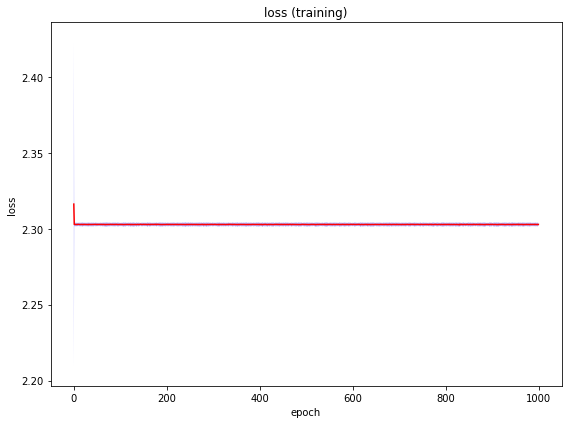


################################################################################
#
# RESULT # 02
#
################################################################################



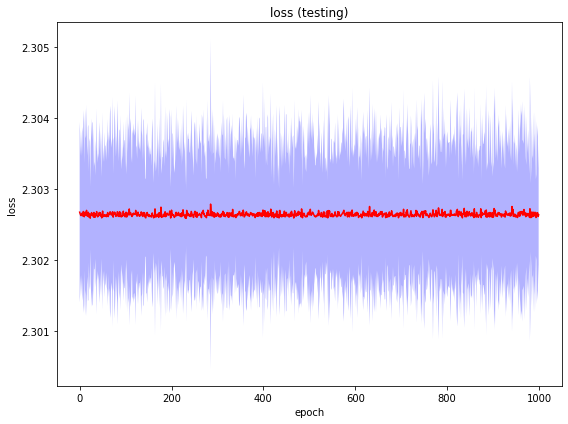


################################################################################
#
# RESULT # 03
#
################################################################################



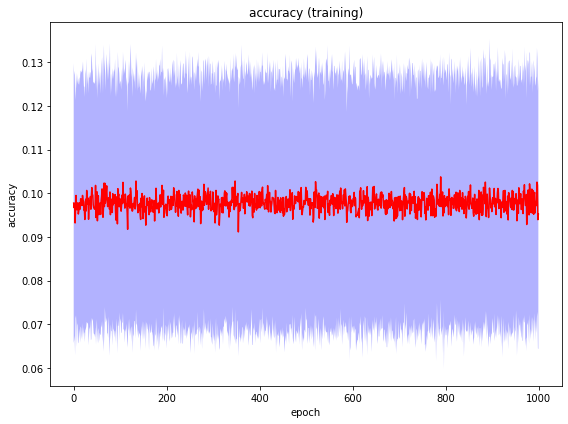


################################################################################
#
# RESULT # 04
#
################################################################################



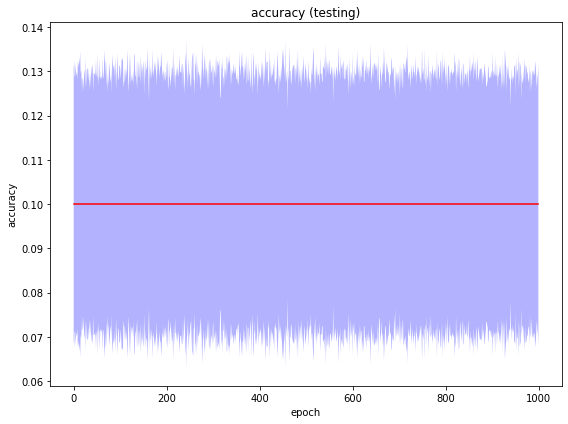


################################################################################
#
# RESULT # 05
#
################################################################################

final training accuracy = 0.09520000

################################################################################
#
# RESULT # 06
#
################################################################################

final testing accuracy = 0.10000000


In [77]:
number_result = 6 

for i in range(number_result):

    title           = '# RESULT # {:02d}'.format(i+1) 
    name_function   = 'function_result_{:02d}()'.format(i+1)

    print('') 
    print('################################################################################')
    print('#') 
    print(title)
    print('#') 
    print('################################################################################')
    print('') 

    eval(name_function)